In [241]:
import modern_robotics as mr
import numpy as np
import csv
import matplotlib.pyplot as plt

In [242]:
# MILESTONE 1
def odometry(u,dt,phi):
    """""
    Takes in the wheel speed and outputs the chassis next position for a 4 macanan wheel robot
    
    (Helper function)

    :param config_chassis - currrent chassis configuration
    :param u - wheel speeds
    :param dt - timestep
    
    :output dq - chassis change in configuration over time dt (3 variables)
    """""
    # Define constants for omnidirectional mobile base (defined in meters)
    l = 0.47/2
    w = 0.3/2
    r = 0.0475

    # Find delta_theta
    delta_theta = u
    
    # Define the 3x4 F matrix (the inverse of the H matrix)
    F = r/4 * np.array([[-1/(l+w),1/(l+w),1/(l+w),-1/(l+w)],[1,1,1,1],[-1,1,-1,1]])

    # Find the twist
    v = np.dot(F,delta_theta) # might not be transposed depending on the shape

    # Collect velocitys linear and angular
    wbz,vbx,vby = v[0],v[1],v[2]

    # Generate q_b
    if mr.NearZero(wbz):
        q_b = np.array([0,vbx,vby]).T
    else:
        dxb = (vbx*np.sin(wbz) + vby*(np.cos(wbz)-1))/wbz
        dyb = (vby*np.sin(wbz) + vbx*(1-np.cos(wbz)))/wbz
        q_b = np.array([wbz,dxb,dyb]).T

    # Transform to space frame
    R = np.array([[1,0,0],[0,np.cos(phi),-np.sin(phi)],[0,np.sin(phi),np.cos(phi)]])
    q = np.dot(R,q_b)

    # Multiply by change in time
    return q * dt

def NextState(configuration, controls, dt, max_ang_speed):
    """""
    Simulator for the kinematics of the youBot. Based on a simple first-order Euler step.

    :param configuration - A 12-vector representing the current configuration of the robot 
        (3 variables for the chassis configuration, 5 variables for the arm configuration, and 
        4 variables for the wheel angles).
    :param controls - A 9-vector of controls indicating the wheel speeds u  (4 variables)
        and the arm joint speeds theta_dot(5 variables).
    :param dt - timestep
    :param max_ang_speed - A positive real value indicating the maximum angular speed of 
        the arm joints and the wheels. For example, if this value is 12.3, the angular speed 
        of the wheels and arm joints is limited to the range [-12.3 radians/s, 12.3 radians/s]. 
        Any speed in the 9-vector of  controls that is outside this range will be set to the 
        nearest boundary of the range. If you don't want speed limits, just use a very large number. 
        If you prefer, your function can accept separate speed limits for the wheels and arm joints.

    :output new_config - A 12-vector representing the configuration of the robot time Δt later.
    
    Example:
        # Define parameters
        configuration = np.zeros(12)
        u = np.array([-10,10,10,-10])
        theta_dot = np.zeros(5)
        controls = np.hstack([u,theta_dot]).flatten()
        dt = .01
        max_ang_speed = 100
        configuration_history = [np.hstack([configuration,0])]

        # Run simulation for 100 time steps
        for i in range(0,100):
            configuration = NextState(configuration, controls, dt, max_ang_speed)
            configuration_history.append(np.hstack([configuration,0]))
    
    """""
    # Access speed limit
    speed_limit = [-max_ang_speed,max_ang_speed]    # maximum speeds

    # Check speed limit
    for i in range(len(controls)):
        if controls[i] > speed_limit[1]:
            controls[i] = speed_limit[1]
        elif controls[i] < speed_limit[0]:
            controls[i] = speed_limit[0]

    # Access config and speed data
    config_chassis = configuration[0:3]             # chassis config
    config_arm = configuration[3:8]                 # arm config
    config_wheel = configuration[8:12]              # wheel config
    u = controls[0:4]                               # wheel speeds 
    theta_dot = controls[4:9]                       # arm speeds
    
    # Update configurations using first-order eluer integration
    new_config_wheel = config_wheel + u * dt
    new_config_arm = config_arm + theta_dot * dt
    new_config_chassis = config_chassis + odometry(u,dt,phi=config_chassis[0])

    return np.hstack([new_config_chassis,new_config_arm,new_config_wheel])
    

In [243]:
# CHECK FOR MILESTONE 1
configuration = np.zeros(12)
u = np.array([-10,10,10,-10])
theta_dot = np.zeros(5)
controls = np.hstack([u,theta_dot]).flatten()
dt = .01
max_ang_speed = 100
configuration_history = [np.hstack([configuration,0])]

for i in range(0,100):
    configuration = NextState(configuration, controls, dt, max_ang_speed)
    configuration_history.append(np.hstack([configuration,0]))

# Write to csv file for testing
with open("configuration.csv",'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(configuration_history)

In [244]:
# MILESTONE 2
def TrajectoryGenerator(T_se_initial,T_sc_initial,T_sc_final,T_ce_grasp,T_ce_standoff,k):
    """""
    Generate the reference trajectory for the end-effectir frame {e}, consisting of eight concatonated trajectory segments.

    :param T_se_initial - The initial configuration of the end-effector in the reference trajectory
    :param T_sc_initial - The cube's initial configuration
    :param T_sc_final - The cube's desired final configuration
    :param T_ce_grasp - The end-effector's configuration relative to the cube when it is grasping the cube
    :param T_ce_standoff - The end-effector's standoff configuration above the cube, before and after grasping, relative to the cube
    :param k - The number of trajectory reference configurations per 0.01 seconds

    :output output_list - A representation of the N configurations of the end-effector along the entire concatenated eight-segment reference trajectory. 
    :output reference_trajectory.csv - A csv file with the entire eight-segment reference trajectoryEach line of the csv file corresponds to one configuration T_se of the end-effector, expressed as 13 variables separated by commas. The 13 variables are, in order,
    r11, r12, r13, r21, r22, r23, r31, r32, r33, px, py, pz, gripper state

    Example:
        # Initialize
        T_sc_initial = np.array([[1,0,0,1],[0,1,0,0],[0,0,1,0.025],[0,0,0,1]])
        T_sc_final= np.array([[0,1,0,0],[-1,0,0,-1],[0,0,1,0.025],[0,0,0,1]])
        T_se_initial = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,.5],[0,0,0,1]])
        T_ce_grasp = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),0],[0,0,0,1]])
        T_ce_standoff = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),.25],[0,0,0,1]])
        k = 1

        # Run
        trajectory = TrajectoryGenerator(T_se_initial,T_sc_initial,T_sc_final,T_ce_grasp,T_ce_standoff,k)
    """""
    # Max linear velocity (m/s)
    max_vel = .15

    # Generate extra reference transformations
    T_se_standoff_init = np.dot(T_sc_initial,T_ce_standoff) # end effector standoff in {s} frame before moving block
    T_se_standoff_final = np.dot(T_sc_final,T_ce_standoff) # end effector standoff in {s} frame after moving block
    T_se_grasp_initial = np.dot(T_sc_initial,T_ce_grasp) #
    T_se_grasp_final = np.dot(T_sc_final,T_ce_grasp) # 

    # Create list of important points in trajectory
    key_steps = [T_se_initial,T_se_standoff_init,T_se_grasp_initial,T_se_grasp_initial,T_se_standoff_init,T_se_standoff_final,T_se_grasp_final,T_se_grasp_final,T_se_standoff_final]
    
    # Create list to define when gripper is activatied
    gripper_state_array = [0,0,1,1,1,1,0,0]

    # Initialize output storage array
    output_list = []

    for jj in range(len(key_steps)-1):
        # Find distance between current and next position
        distance = np.linalg.norm(key_steps[jj+1][0:3,3]-key_steps[jj][0:3,3])

        # Derive time of movement using max velocity and distance to next position
        time_derived = distance/max_vel if distance/max_vel != 0 else 0.63

        # Calculate reference trajectory using screw path and 5th order polynomial time scaling
        output = mr.CartesianTrajectory(key_steps[jj],key_steps[jj+1],Tf = time_derived,N = time_derived*k/0.01, method = 3)
        
        # Activate gripper according to predefined list
        gripper_state = gripper_state_array[jj]

        # Store all reference transformation matricies and gripper state
        for i in range(np.shape(output)[0]):
            output_list.append(np.array([output[i][0,0],output[i][0,1],output[i][0,2],
                                        output[i][1,0],output[i][1,1],output[i][1,2],
                                        output[i][2,0],output[i][2,1],output[i][2,2],
                                        output[i][0,3],output[i][1,3],output[i][2,3],
                                        gripper_state])) 

    # Write to CSV
    with open("reference_trajectory.csv",'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(output_list)

    
    return np.array(output_list)

In [245]:
# CHECK FOR MILESTONE 2
T_sc_initial = np.array([[1,0,0,1],[0,1,0,0],[0,0,1,0.025],[0,0,0,1]])
T_sc_final= np.array([[0,1,0,0],[-1,0,0,-1],[0,0,1,0.025],[0,0,0,1]])
T_se_initial = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,.5],[0,0,0,1]])
T_ce_grasp = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),0],[0,0,0,1]])
T_ce_standoff = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),.25],[0,0,0,1]])
k = 1

# Run
trajectory = TrajectoryGenerator(T_se_initial,T_sc_initial,T_sc_final,T_ce_grasp,T_ce_standoff,k)

In [246]:
# MILESTONE 3
def get_transformation(configuration):
    """""
    Returns the transformation representation of the end effector at a given configuration
    
    (Helper function)
    
    :param configuartion - the 13 vector configuaration

    :output X - The end effector configuration
    """""
    # Define arm twists
    l1, l2, l3, l4, l5  = 0.147, 0.155, 0.135, 0.2176, 0.033
    Blist = np.array([[0,0,1.0,0,l5,0],[0,-1.0,0,-l4-l3-l2,0,0],[0,-1.0,0,-l4-l3,0,0],[0,-1.0,0,-l4,0,0],[0,0,1.0,0,0,0]]).T

    # Extract configurations
    config_chassis = configuration[0:3]             # chassis config
    config_arm = configuration[3:8]                 # arm config
    phi, x, y = config_chassis[0], config_chassis[1], config_chassis[2]

    T_sb = np.array([[np.cos(phi),-np.sin(phi),0,x],[np.sin(phi),np.cos(phi),0,y],[0,0,1,0.0963],[0,0,0,1]])
    M_0e = np.array([[1.0,0,0,0.033],[0,1.,0,0],[0,0,1.0,0.6546],[0,0,0,1.0]])     # Home transformation
    T_0e = mr.FKinBody(M_0e,Blist,config_arm)                               # Transformation from {0} to {e}
    T_b0 = np.array([[1.0,0,0,0.1662],[0,1.0,0,0],[0,0,1.0,0.0026],[0,0,0,1.0]])    # Transformation from {b} to {0}
    T_s0 = np.dot(T_sb,T_b0)
    T_se = np.dot(T_s0,T_0e)
    X = T_se

    return X

def get_jacobian(configuration):
    """""
    Calculate and return the mobile manipulator jacobian.

    (Helper function)
    :param configuration - Gives the current configuration of the mobile manipulator
    :output J_e - Mobile manipulator jacobian
    """""
    # Define arm lengths and wheel distance to chassis {b} frame
    l1, l2, l3, l4, l5  = 0.147, 0.155, 0.135, 0.2176, 0.033
    l, w, r = 0.47/2.0, 0.3/2.0, 0.0475

    # Define arm twists
    Blist = np.array([[0,0,1.0,0,l5,0],[0,-1.0,0,-l4-l3-l2,0,0],[0,-1.0,0,-l4-l3,0,0],[0,-1.0,0,-l4,0,0],[0,0,1.0,0,0,0]]).T

    # Extract config values
    config_arm = configuration[3:8]                 # arm config

    # Define transformations 
    M_0e = np.array([[1.0,0,0,0.033],[0,1.,0,0],[0,0,1.0,0.6546],[0,0,0,1.0]])     # Home transformation
    T_0e = mr.FKinBody(M_0e,Blist,config_arm)                               # Transformation from {0} to {e}
    T_b0 = np.array([[1.0,0,0,0.1662],[0,1.0,0,0],[0,0,1.0,0.0026],[0,0,0,1.0]])    # Transformation from {b} to {0}

    # Find J_base
    F = r/4.0 * np.array([[-1.0/(l+w),1.0/(l+w),1.0/(l+w),-1.0/(l+w)],[1.0,1.0,1.0,1.0],[-1.0,1.0,-1.0,1.0]])
    F6 = np.vstack([np.zeros(np.shape(F)[1]),np.zeros(np.shape(F)[1]),F,np.zeros(np.shape(F)[1])])
    J_base = np.dot(mr.Adjoint(np.dot(mr.TransInv(T_0e),mr.TransInv(T_b0))),F6)
    
    # Find J_arm
    J_arm = mr.JacobianBody(Blist,config_arm)

    # Derive J_e
    J_e = np.hstack([J_base,J_arm])

    return J_e

def testJointLimits(q):
    """""    
    Test the joint angles produced by FeedbackControl to see if they violate joint limits.
    (Helper function)
    :param q - configuration

    :output - 5 vector with 1 for joints that have voilated a joint limit
    """""
    joint_mins = np.array([-1.5,-2,-2,-2,-1])
    joint_maxs = np.array([1.5,2,2,2,1])
    # joint_mins = np.array([-1.5,.2,.2,-1,-1])
    # joint_maxs = np.array([1.5,3,2,2,1])

    out = np.zeros(5)
    config_arm = q[3:8]
    for ii in range(5):
        if config_arm[ii] > joint_maxs[ii]:
            out[ii] = 1
        if config_arm[ii] < joint_mins[ii]:
            out[ii] = 1

    return out
    
def FeedbackControl(q,X_d,X_d_next,dt,K_p,K_i,X_err_integrated):
    """""
    Calculates the kinematic task-space feedback control of a mobile manipulator.

    :param q - The 13 vector actual configuration
    :param X_d - The list version of (T_se_d) The current end-effector reference configuration
    :param X_d_next - The list version of (T_se_d_next) The end-effector reference configuration at the next timestep in the reference trajectory at a dt time later
    :param K_p - Proportional gain
    :param K_i - Integral gain
    :param X_err_integrated - The integrated error

    :output joint_speeds - The joint speeds output by the feedback controller
    :output X_err_integrated - Integrated error, passed to be input for next time
    :output X_err - The twist error for plotting

    Example:

        # Define inputs
        q = np.array([0,0,0,0,0,0.200,-1.600,0,0,0,0,0,0])
        X_d = np.array([0,0,1,0,1,0,-1,0,0,.5,0,.5])
        X_d_next = np.array([0,0,1,0,1,0,-1,0,0,0.6,0,0.3])
        K_p = 0*np.eye(6)
        K_i = 0*np.eye(6)
        dt = 0.01
        X_err_integrated = 0

        # Run code
        joint_speeds,X_err,X_err_integrated = FeedbackControl(q,X_d,X_d_next,dt,K_p,K_i,X_err_integrated)

        output:
        joint_speeds = [ 157.1696  157.1696  157.1696  157.1696    0.     -652.8874 1398.5895 -745.7022   -0.    ]

    """""
    # Get state in transformation matricies
    X = get_transformation(q)                  # (T_se) The current actual end-effector configuration

    X_d = np.array([[X_d[0],X_d[1],X_d[2],X_d[9]],
                    [X_d[3],X_d[4],X_d[5],X_d[10]],
                    [X_d[6],X_d[7],X_d[8],X_d[11]],
                    [0     ,0     ,0     ,1      ]])             # (T_se_d) The current end-effector reference configuration
    X_d_next = np.array([[X_d_next[0],X_d_next[1],X_d_next[2],X_d_next[9]],
                         [X_d_next[3],X_d_next[4],X_d_next[5],X_d_next[10]],
                         [X_d_next[6],X_d_next[7],X_d_next[8],X_d_next[11]],
                         [0          ,0          ,0          ,1           ]])         # (T_se_d_next) The end-effector reference configuration at the next timestep in the reference trajectory at a dt time later
                        
    # Get mobile manipulator jacobian
    J_e = get_jacobian(q)
    
    # ******* CONTROLLER *******

    # Calculate the error twst
    X_err = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(X),X_d)))

    # Update the integrated error
    X_err_integrated += X_err * dt

    # Extract feedforward reference
    V_d = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(X_d),X_d_next)))/float(dt)

    # Find commanded twist with PI control
    ff = np.dot(mr.Adjoint(np.dot(mr.TransInv(X),X_d)), V_d)    # Feed forward
    P = np.dot(K_p,X_err)                                       # Proportional response
    I = np.dot(K_i,X_err_integrated)                            # Integral response
    
    # Find command twist
    V = ff + P + I                  

    # Convert to joint speeds using J_e
    joint_speeds = np.dot(np.linalg.pinv(J_e,1e-4),V)

    # # # Joint limits
    # Detect joints that have violated joint limits
    out = testJointLimits(NextState(q,joint_speeds,dt,max_ang_speed=100))

    # Get index of violating joints
    index = np.where(out==1)[0]

    # If there are offending joints...
    if len(index) > 0:

        for col in index:
            # Remove their column from the jacobian to remove movement at that joint
            J_e[:,col+3] *= 0

        # Re-calculate joint speeds
        joint_speeds = np.dot(np.linalg.pinv(J_e,1e-4),V)

    return joint_speeds, X_err, X_err_integrated

In [247]:
# MILESTONE 3 CHECK
q = np.array([0,0,0,0,0,0.200,-1.600,0,0,0,0,0,0])
X_d = np.array([0,0,1,0,1,0,-1,0,0,.5,0,.5])
X_d_next = np.array([0,0,1,0,1,0,-1,0,0,0.6,0,0.3])
K_p = 0*np.eye(6)
K_i = 0*np.eye(6)
dt = 0.01
X_err_integrated = 0

# Test FeedbackControl
joint_speeds,X_err,X_err_integrated = FeedbackControl(q,X_d,X_d_next,dt,K_p,K_i,X_err_integrated)

(2414, 6)


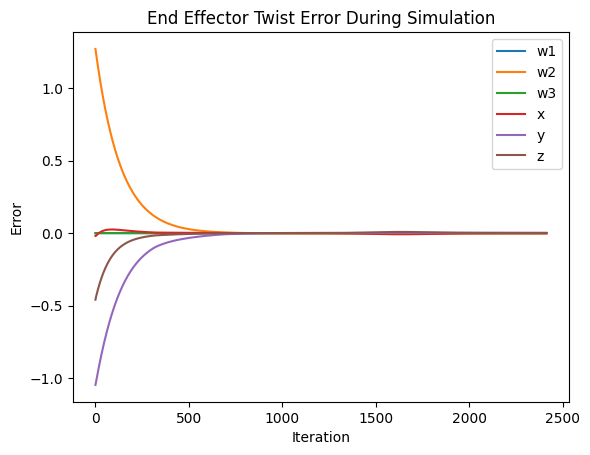

In [249]:

# FULL PROGRAM

# Initialize (TrajectoryGenerator)
M_se = get_transformation(configuration=np.zeros(13))           # Home config
T_se = np.array([[0,0,1,0],[0,1,0,0],[-1,0,0,.5],[0,0,0,1]])    # Final project specified starting point

# Key positions for TrajectoryGenerator
T_sc_initial = np.array([[1,0,0,1],[0,1,0,0],[0,0,1,0.025],[0,0,0,1]])
T_sc_final= np.array([[0,1,0,0],[-1,0,0,-1],[0,0,1,0.025],[0,0,0,1]])
T_ce_grasp = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),0],[0,0,0,1]])
T_ce_standoff = np.array([[-1/np.sqrt(2),0,1/np.sqrt(2),0],[0,1,0,0],[-1/np.sqrt(2),0,-1/np.sqrt(2),.25],[0,0,0,1]])
k = 1

# Get reference trajectory
trajectory = TrajectoryGenerator(T_se,T_sc_initial,T_sc_final,T_ce_grasp,T_ce_standoff,k)

# Initialize (FeedbackControl)
starting_q = np.array([0,.05,np.pi/3,0,-.1,-.1,-.1,0,0,0,0,0])  # Starting configuration
K_p = .75*np.eye(6)         # P gain
K_i = 0.001*np.eye(6)       # I gain
dt = 0.01                   # Timestep
X_err_integrated = 0        # Integrated error init

# Run loop

# Start recording configuration and error
q_hist = [np.hstack([starting_q,trajectory[0][-1]])]
X_err_hist = []

q = starting_q

# Loop through all the desired configurations
for ii in range(0,np.shape(trajectory)[0]-1):
    # Save desired and next desired config for the FeedbackControl function
    X_d = trajectory[ii]
    X_d_next = trajectory[ii+1]

    # Find joint speeds
    joint_speeds,X_err,X_err_integrated = FeedbackControl(q,X_d,X_d_next,dt,K_p,K_i,X_err_integrated)

    # Get new configuration
    q = NextState(configuration=q,controls=joint_speeds,dt=dt,max_ang_speed=100)

    # Save configuration and errors for .csv files and plotting
    q_hist.append(np.hstack([q,trajectory[ii][-1]]))
    X_err_hist.append(X_err)

# Save configurations to .csv file
with open("q_final.csv",'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(q_hist)

# Save error to .csv file
with open("X_err.csv",'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(X_err_hist)

# Plot the error
plt.figure()
X_err_hist=np.array(X_err_hist)
print(np.shape(X_err_hist))
for i in range(0,6):
    plt.plot(X_err_hist[:,i])

plt.title("End Effector Twist Error During Simulation")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.legend(["w1","w2","w3","x","y","z"])

